In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
pjme = pd.read_csv('PJME_hourly.csv', index_col=[0], parse_dates=[0])

In [3]:
pjme.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
pjme.tail(10)

,PJME_MW
Datetime,
2018-01-01 15:00:00,38737.0
2018-01-01 16:00:00,39337.0
2018-01-01 17:00:00,41213.0
2018-01-01 18:00:00,44147.0
2018-01-01 19:00:00,44343.0
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0


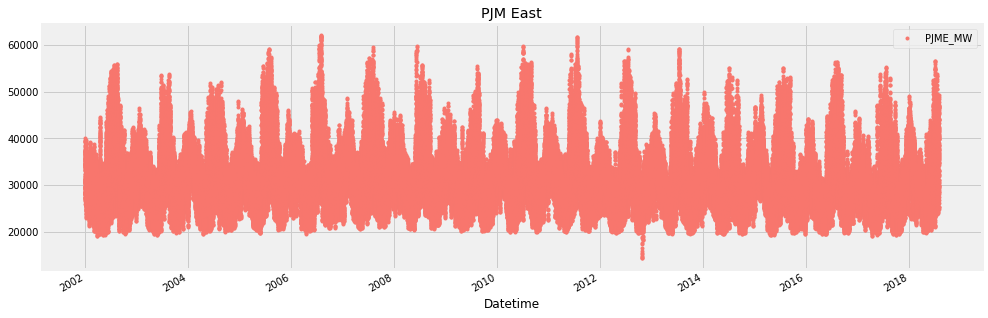

In [5]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = pjme.plot(style='.', figsize=(15,5), color=color_pal[0], title='PJM East')

## 测试集与训练集划分

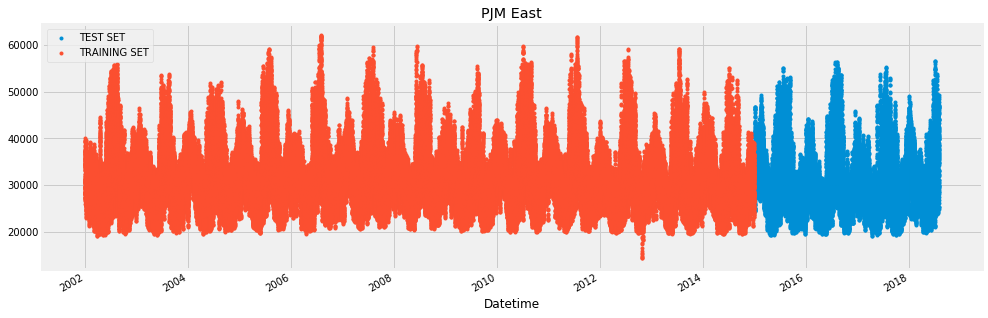

In [6]:
split_date = '01-Jan-2015'
pjme_train = pjme.loc[pjme.index <= split_date].copy()
pjme_test = pjme.loc[pjme.index > split_date].copy()
_ = pjme_test \
    .rename(columns={'PJME_MW': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'PJME_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.')

## 建立时序特征

In [7]:
pjme_train.iloc[0].index

Index(['PJME_MW'], dtype='object')

In [8]:
def create_features(df, label=None):

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X


In [9]:
X_train, y_train = create_features(pjme_train, label='PJME_MW')
X_test, y_test = create_features(pjme_test, label='PJME_MW')

In [10]:
X_test.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2015-12-31 01:00:00,1,3,4,12,2015,365,31,53
2015-12-31 02:00:00,2,3,4,12,2015,365,31,53
2015-12-31 03:00:00,3,3,4,12,2015,365,31,53
2015-12-31 04:00:00,4,3,4,12,2015,365,31,53
2015-12-31 05:00:00,5,3,4,12,2015,365,31,53


## 数据建模

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
          verbose=True)

D:\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Anaconda3\envs\tensorflow\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[17:19:28] WARNING: d:\build\xgboost\xgboost-0.90.git\src\objective\regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:29710.4	validation_1-rmse:28762.5
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:26822.6	validation_1-rmse:25892.2
[2]	validation_0-rmse:24211.2	validation_1-rmse:23286.6
[3]	validation_0-rmse:21885	validation_1-rmse:20967.5
[4]	validation_0-rmse:19780.3	validation_1-rmse:18868.5
[5]	validation_0-rmse:17910	validation_1-rmse:17017.7
[6]	validation_0-rmse:16216.1	validation_1-rmse:15336.4
[7]	validation_0-rmse:14717.8	validation_1-rmse:13861.5
[8]	validation_0-rmse:13377.4	validation_1-rmse:12536.3
[9]	validation_0-rmse:12184.1	validation_1-rmse:11362.1
[10]	validation_0-rmse:11099.4	validation_1-rmse:10298.7
[11]	validation_0-rmse:10135.2	validation_1-rmse:9357.58
[12]	validation_0-rms

[139]	validation_0-rmse:2939.9	validation_1-rmse:3720.9
[140]	validation_0-rmse:2939.16	validation_1-rmse:3719.24
[141]	validation_0-rmse:2935.64	validation_1-rmse:3715.27
[142]	validation_0-rmse:2934.18	validation_1-rmse:3715.1
[143]	validation_0-rmse:2933.73	validation_1-rmse:3715.9
[144]	validation_0-rmse:2933.1	validation_1-rmse:3715.75
[145]	validation_0-rmse:2932.23	validation_1-rmse:3716.29
[146]	validation_0-rmse:2931.2	validation_1-rmse:3717.22
[147]	validation_0-rmse:2930.35	validation_1-rmse:3718.02
[148]	validation_0-rmse:2928.75	validation_1-rmse:3717.76
[149]	validation_0-rmse:2923.14	validation_1-rmse:3712.2
[150]	validation_0-rmse:2920.09	validation_1-rmse:3714.78
[151]	validation_0-rmse:2919.09	validation_1-rmse:3714.25
[152]	validation_0-rmse:2918.28	validation_1-rmse:3713.52
[153]	validation_0-rmse:2917.79	validation_1-rmse:3713.66
[154]	validation_0-rmse:2917.19	validation_1-rmse:3714.73
[155]	validation_0-rmse:2916.37	validation_1-rmse:3714.26
[156]	validation_0-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

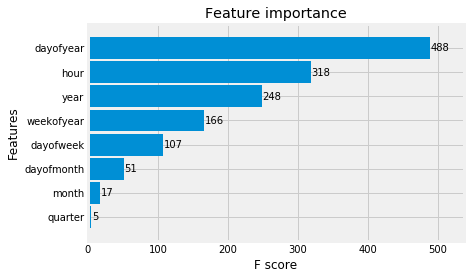

In [12]:
_ = plot_importance(reg, height=0.9)

In [14]:
pjme_test['MW_Prediction'] = reg.predict(X_test)
pjme_all = pd.concat([pjme_test, pjme_train], sort=False)

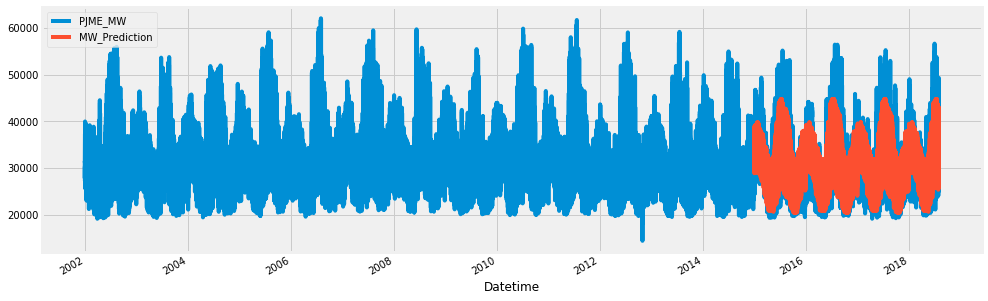

In [15]:
_ = pjme_all[['PJME_MW','MW_Prediction']].plot(figsize=(15, 5))

In [16]:
##增加误差找出最好的最差的
pjme_test['error'] = pjme_test['PJME_MW'] - pjme_test['MW_Prediction']
pjme_test['abs_error'] = pjme_test['error'].apply(np.abs)
error_by_day = pjme_test.groupby(['year','month','dayofmonth']) \
    .mean()[['PJME_MW','MW_Prediction','error','abs_error']]

In [17]:
error_by_day.sort_values('error', ascending=True).head(10)

PJME_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2016 7     4           28399.958333   36986.964844 -8587.006429  8587.006429
2017 2     24          26445.083333   33814.503906 -7369.422445  7369.422445
2015 12    25          24466.083333   31584.923828 -7118.841390  7118.841390
2017 2     20          27070.583333   34100.781250 -7030.197754  7030.197754
2015 7     3           30024.875000   37021.031250 -6996.156169  6996.156169
2017 6     28          30531.208333   37526.589844 -6995.380371  6995.380371
     2     8           28523.833333   35511.699219 -6987.864258  6987.864258
     9     2           24201.458333   31180.390625 -6978.933105  6978.933105
     2     25          24344.458333   31284.279297 -6939.820150  6939.820150
2018 2     21          27572.500000   34477.417969 -6904.919352  6904.919352

In [19]:
error_by_day.sort_values('error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31753.224609  13432.608887  13432.608887
           14          44427.333333   31058.818359  13368.514404  13368.514404
     9     10          40996.166667   29786.179688  11209.987793  11209.987793
           9           43836.958333   32831.035156  11005.923828  11005.923828
2015 2     20          44694.041667   33814.503906  10879.535889  10879.535889
2018 1     6           43565.750000   33435.265625  10130.485921  10130.485921
2016 8     12          45724.708333   35609.312500  10115.394287  10115.394287
2017 5     19          38032.583333   28108.976562   9923.606689   9923.606689
     12    31          39016.000000   29314.683594   9701.315430   9701.315430
2015 2     21          40918.666667   31284.279297   9634.388184   9634.388184

In [18]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

PJME_MW  MW_Prediction         error     abs_error
year month dayofmonth                                                         
2016 8     13          45185.833333   31753.224609  13432.608887  13432.608887
           14          44427.333333   31058.818359  13368.514404  13368.514404
     9     10          40996.166667   29786.179688  11209.987793  11209.987793
           9           43836.958333   32831.035156  11005.923828  11005.923828
2015 2     20          44694.041667   33814.503906  10879.535889  10879.535889
2018 1     6           43565.750000   33435.265625  10130.485921  10130.485921
2016 8     12          45724.708333   35609.312500  10115.394287  10115.394287
2017 5     19          38032.583333   28108.976562   9923.606689   9923.606689
     12    31          39016.000000   29314.683594   9701.315430   9701.315430
2015 2     21          40918.666667   31284.279297   9634.388184   9634.388184

In [20]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

PJME_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2016 10    3           27705.583333   27775.351562  -69.768148  229.585205
2015 10    28          28500.958333   28160.875000  340.083740  388.023356
2016 10    8           25183.333333   25535.669922 -352.337402  401.017090
     5     1           24503.625000   24795.419922 -291.794515  428.289307
2017 10    29          24605.666667   24776.271484 -170.605225  474.628988
2016 9     16          29258.500000   29397.271484 -138.770833  491.070312
     3     20          27989.416667   27620.132812  369.284831  499.750488
     10    2           24659.083333   25134.919922 -475.836670  516.188232
2017 10    14          24949.583333   25399.728516 -450.145996  520.855794
2015 5     6           28948.666667   28710.271484  238.396077  546.640544

In [ ]:
### 10月绝对误差比较小  